# Comprehensive Sentiment Analysis on Amazon Product Reviews

This notebook performs sentiment analysis on Amazon product reviews across 5 different categories:
- Books
- Ebooks
- Grocery
- Jewelry
- PC/Electronics

We'll use multiple classifiers and create comprehensive visualizations to analyze sentiment patterns.

In [3]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## 1. Import Libraries and Setup

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
# Build per-class metrics table
from sklearn.metrics import precision_recall_fscore_support

# Visualization libraries
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Data Loading and Exploration

In [2]:
# Load all CSV files
def load_datasets():
    """
    Load all Amazon product review datasets and combine them.
    """
    datasets = {
        'books': 'datasets/amazon_books_Data.csv',
        'ebooks': 'datasets/amazon_ebook_Data.csv',
        'grocery': 'datasets/amazon_grocery_Data.csv',
        'jewelry': 'datasets/amazon_jwellery_Data.csv',
        'pc': 'datasets/amazon_pc_Data.csv'
    }
    
    combined_data = []
    
    for category, filepath in datasets.items():
        try:
            # Load dataset
            df = pd.read_csv(filepath)
            
            # Add category column
            df['category'] = category
            
            # Standardize sentiment column name
            sentiment_cols = [col for col in df.columns if 'sentiment' in col.lower()]
            if sentiment_cols:
                df['sentiment'] = df[sentiment_cols[0]]
            
            # Select relevant columns
            if 'review_body' in df.columns:
                df_clean = df[['review_body', 'sentiment', 'category', 'star_rating']].copy()
                combined_data.append(df_clean)
                print(f"Loaded {category}: {len(df_clean)} reviews")
            else:
                print(f"Warning: review_body column not found in {category}")
                
        except Exception as e:
            print(f"Error loading {category}: {str(e)}")
    
    # Combine all datasets
    if combined_data:
        final_df = pd.concat(combined_data, ignore_index=True)
        return final_df
    else:
        print("No data loaded successfully")
        return pd.DataFrame()

# Load the data
df = load_datasets()
print(f"\nTotal combined dataset: {len(df)} reviews")
print(f"Dataset shape: {df.shape}")

Loaded books: 100 reviews
Loaded ebooks: 100 reviews
Loaded grocery: 100 reviews
Loaded jewelry: 100 reviews
Loaded pc: 100 reviews

Total combined dataset: 500 reviews
Dataset shape: (500, 4)


In [3]:
# Explore the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nDataset description:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  500 non-null    object
 1   sentiment    500 non-null    object
 2   category     500 non-null    object
 3   star_rating  500 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 15.8+ KB
None

First few rows:
                                         review_body sentiment category  \
0               "I love it and so does my students!"  positive    books   
1  "My wife and I ordered 2 books and gave them a...  positive    books   
2  "Great book just like all the others in the se...  positive    books   
3                                     "So beautiful"  positive    books   
4  "Enjoyed the author's story and his quilts are...  positive    books   

   star_rating  
0            1  
1            1  
2            1  
3            1  
4            1  

Dataset d

In [4]:
# Check for missing values and data quality
print("Missing values:")
print(df.isnull().sum())

print("\nUnique sentiment values:")
print(df['sentiment'].value_counts())

print("\nCategory distribution:")
print(df['category'].value_counts())

print("\nStar rating distribution:")
print(df['star_rating'].value_counts().sort_index())

Missing values:
review_body    0
sentiment      0
category       0
star_rating    0
dtype: int64

Unique sentiment values:
sentiment
positive    398
negaitve    102
Name: count, dtype: int64

Category distribution:
category
books      100
ebooks     100
grocery    100
jewelry    100
pc         100
Name: count, dtype: int64

Star rating distribution:
star_rating
0    102
1    398
Name: count, dtype: int64


## 3. Data Preprocessing and Cleaning

In [5]:
# Clean and preprocess the data
def clean_data(df):
    """
    Clean and preprocess the dataset.
    """
    # Remove rows with missing review_body or sentiment
    df_clean = df.dropna(subset=['review_body', 'sentiment']).copy()
    
    # Standardize sentiment labels
    df_clean['sentiment'] = df_clean['sentiment'].str.lower().str.strip()
    
    # Map sentiment values to binary (positive=1, negative=0)
    sentiment_mapping = {
        'positive': 1,
        'negaitve': 0,  # Note: there's a typo in the original data
        'negative': 0
    }
    
    df_clean['sentiment_binary'] = df_clean['sentiment'].map(sentiment_mapping)
    
    # Remove rows where sentiment mapping failed
    df_clean = df_clean.dropna(subset=['sentiment_binary'])
    
    # Convert to int
    df_clean['sentiment_binary'] = df_clean['sentiment_binary'].astype(int)
    
    # Remove very short reviews (less than 10 characters)
    df_clean = df_clean[df_clean['review_body'].str.len() >= 10]
    
    print(f"Data cleaned: {len(df_clean)} reviews remaining")
    print(f"Sentiment distribution after cleaning:")
    print(df_clean['sentiment_binary'].value_counts())
    
    return df_clean

# Clean the data
df_clean = clean_data(df)

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(df_clean[['review_body', 'sentiment', 'sentiment_binary', 'category']].head())

Data cleaned: 486 reviews remaining
Sentiment distribution after cleaning:
sentiment_binary
1    384
0    102
Name: count, dtype: int64

Sample of cleaned data:
                                         review_body sentiment  \
0               "I love it and so does my students!"  positive   
1  "My wife and I ordered 2 books and gave them a...  positive   
2  "Great book just like all the others in the se...  positive   
3                                     "So beautiful"  positive   
4  "Enjoyed the author's story and his quilts are...  positive   

   sentiment_binary category  
0                 1    books  
1                 1    books  
2                 1    books  
3                 1    books  
4                 1    books  


In [6]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text for sentiment analysis.
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters and digits, keep only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords and lemmatize tokens.
    """
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_text)

# Apply text preprocessing
print("Preprocessing text...")
df_clean['review_clean'] = df_clean['review_body'].apply(preprocess_text)
df_clean['review_no_stopwords'] = df_clean['review_clean'].apply(remove_stopwords)

# Remove empty reviews after preprocessing
df_clean = df_clean[df_clean['review_no_stopwords'].str.len() > 0]

print(f"Final dataset size: {len(df_clean)} reviews")

# Show example of text preprocessing
print("\nExample of text preprocessing:")
sample_idx = 0
print(f"Original: {df_clean.iloc[sample_idx]['review_body'][:200]}...")
print(f"Cleaned: {df_clean.iloc[sample_idx]['review_clean'][:200]}...")
print(f"No stopwords: {df_clean.iloc[sample_idx]['review_no_stopwords'][:200]}...")

Preprocessing text...
Final dataset size: 486 reviews

Example of text preprocessing:
Original: "I love it and so does my students!"...
Cleaned: i love it and so does my students...
No stopwords: love student...


## 4. Exploratory Data Analysis and Visualization

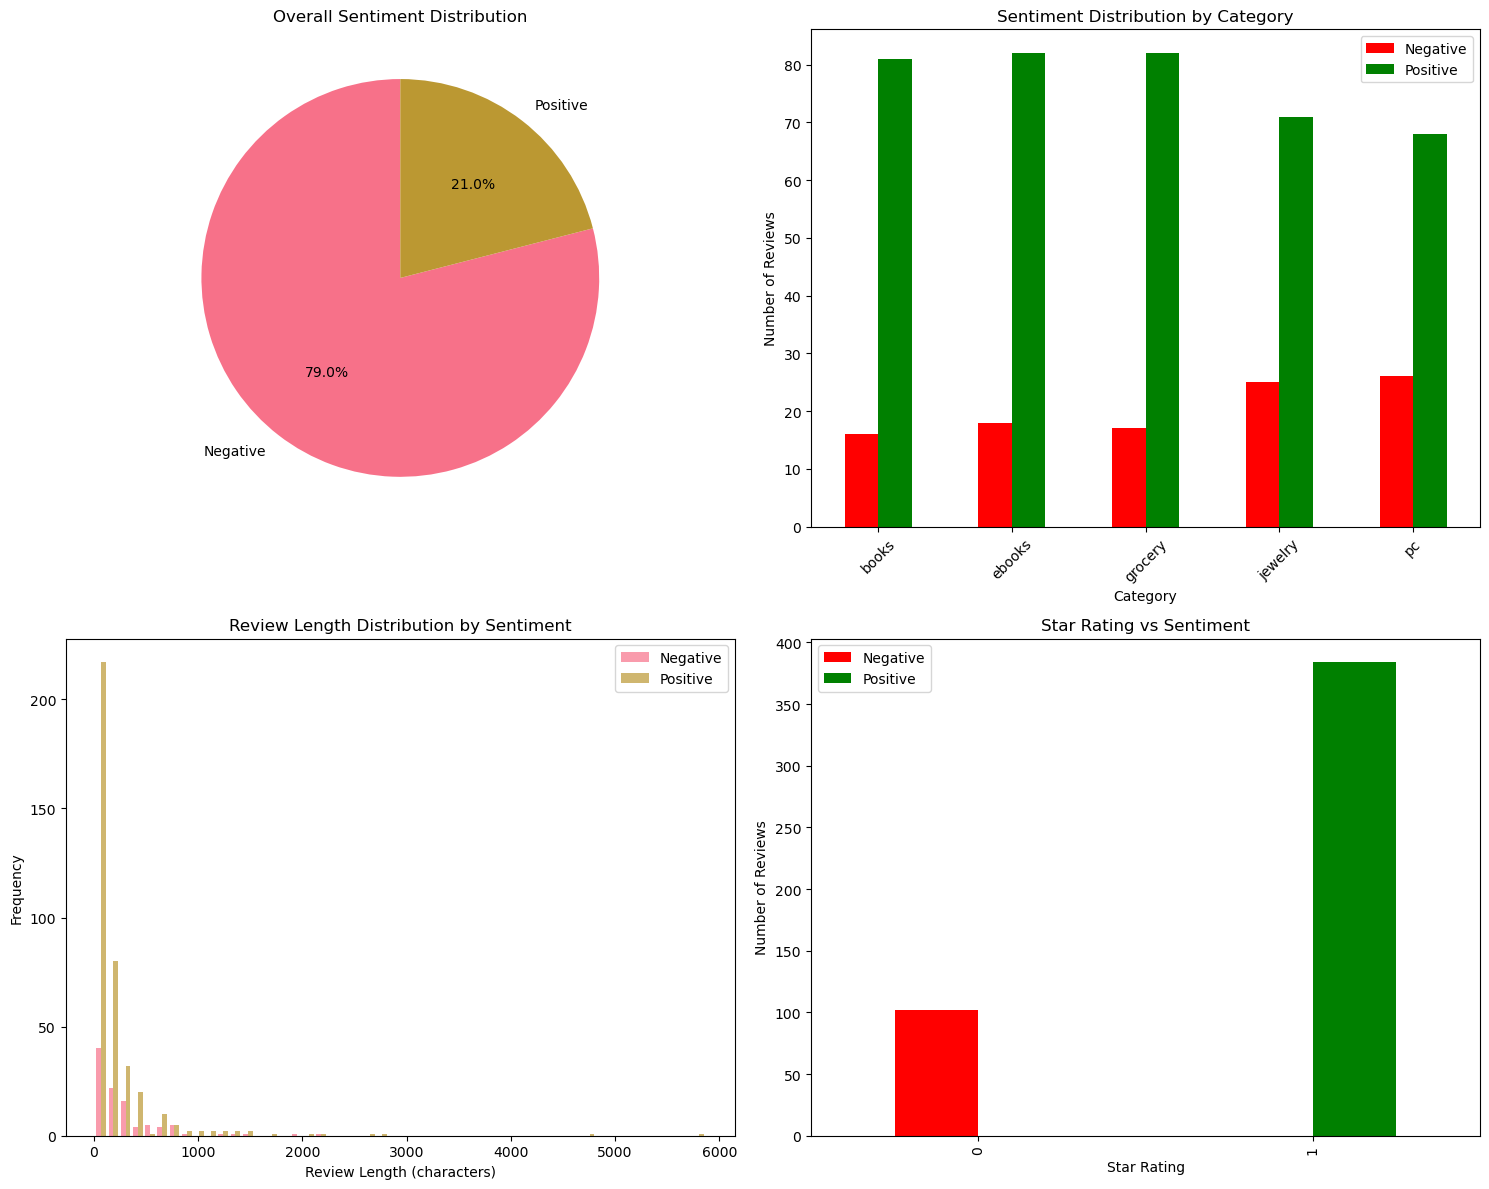

Summary Statistics:
Total reviews: 486
Positive reviews: 384 (79.0%)
Negative reviews: 102 (21.0%)
Average review length: 250.6 characters


In [7]:
# Sentiment distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Overall sentiment distribution
sentiment_counts = df_clean['sentiment_binary'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Overall Sentiment Distribution')

# Sentiment by category
sentiment_by_category = df_clean.groupby(['category', 'sentiment_binary']).size().unstack()
sentiment_by_category.plot(kind='bar', ax=axes[0, 1], color=['red', 'green'])
axes[0, 1].set_title('Sentiment Distribution by Category')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].legend(['Negative', 'Positive'])
axes[0, 1].tick_params(axis='x', rotation=45)

# Review length distribution
df_clean['review_length'] = df_clean['review_body'].str.len()
axes[1, 0].hist([df_clean[df_clean['sentiment_binary']==0]['review_length'], 
                df_clean[df_clean['sentiment_binary']==1]['review_length']], 
               bins=50, alpha=0.7, label=['Negative', 'Positive'])
axes[1, 0].set_title('Review Length Distribution by Sentiment')
axes[1, 0].set_xlabel('Review Length (characters)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Star rating vs sentiment
star_sentiment = df_clean.groupby(['star_rating', 'sentiment_binary']).size().unstack(fill_value=0)
star_sentiment.plot(kind='bar', ax=axes[1, 1], color=['red', 'green'])
axes[1, 1].set_title('Star Rating vs Sentiment')
axes[1, 1].set_xlabel('Star Rating')
axes[1, 1].set_ylabel('Number of Reviews')
axes[1, 1].legend(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Total reviews: {len(df_clean)}")
print(f"Positive reviews: {sum(df_clean['sentiment_binary'])} ({sum(df_clean['sentiment_binary'])/len(df_clean)*100:.1f}%)")
print(f"Negative reviews: {len(df_clean) - sum(df_clean['sentiment_binary'])} ({(len(df_clean) - sum(df_clean['sentiment_binary']))/len(df_clean)*100:.1f}%)")
print(f"Average review length: {df_clean['review_length'].mean():.1f} characters")

## 5. Feature Engineering - Text Vectorization

In [8]:
# Prepare data for modeling
X = df_clean['review_no_stopwords']
y = df_clean['sentiment_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set positive ratio: {sum(y_train)/len(y_train):.3f}")
print(f"Test set positive ratio: {sum(y_test)/len(y_test):.3f}")

Training set size: 388
Test set size: 98
Training set positive ratio: 0.791
Test set positive ratio: 0.786


In [9]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Create Count vectorizer
count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit and transform the training data
print("Creating TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Creating Count features...")
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Count feature matrix shape: {X_train_count.shape}")

# Show some feature names
print("\nSample TF-IDF features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])

Creating TF-IDF features...
Creating Count features...
TF-IDF feature matrix shape: (388, 1216)
Count feature matrix shape: (388, 1216)

Sample TF-IDF features:
['able' 'absolute' 'absolutely' 'absolutely love' 'absolutely loved'
 'access' 'account' 'action' 'actual' 'actually' 'added' 'addicted'
 'addition' 'additional' 'administrator' 'admired' 'admit' 'adorable'
 'advertised' 'advice']


## 6. Model Training - Logistic Regression

In [10]:
# Train Logistic Regression models
print("Training Logistic Regression models...")

# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
lr_tfidf.fit(X_train_tfidf, y_train)

# Logistic Regression with Count Vectorizer
lr_count = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
lr_count.fit(X_train_count, y_train)

# Make predictions
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
y_pred_lr_count = lr_count.predict(X_test_count)

print("Logistic Regression models trained successfully!")

Training Logistic Regression models...
Logistic Regression models trained successfully!


## 7. Model Training - Naive Bayes

In [11]:
# Train Naive Bayes models
print("Training Naive Bayes models...")

# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Naive Bayes with Count Vectorizer
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)

# Make predictions
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
y_pred_nb_count = nb_count.predict(X_test_count)

print("Naive Bayes models trained successfully!")

Training Naive Bayes models...
Naive Bayes models trained successfully!


## 8. Model Evaluation and Performance Comparison

In [12]:
# Function to calculate all metrics
def calculate_metrics(y_true, y_pred, model_name):
    """
    Calculate and return all evaluation metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calculate metrics for all models
models_performance = []

models_performance.append(calculate_metrics(y_test, y_pred_lr_tfidf, 'Logistic Regression + TF-IDF'))
models_performance.append(calculate_metrics(y_test, y_pred_lr_count, 'Logistic Regression + Count'))
models_performance.append(calculate_metrics(y_test, y_pred_nb_tfidf, 'Naive Bayes + TF-IDF'))
models_performance.append(calculate_metrics(y_test, y_pred_nb_count, 'Naive Bayes + Count'))

# Create performance DataFrame
performance_df = pd.DataFrame(models_performance)
print("Model Performance Comparison:")
print(performance_df.round(4))

Model Performance Comparison:
                          Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression + TF-IDF    0.7653     0.8857  0.8052    0.8435
1   Logistic Regression + Count    0.7857     0.8784  0.8442    0.8609
2          Naive Bayes + TF-IDF    0.7857     0.7857  1.0000    0.8800
3           Naive Bayes + Count    0.8061     0.8222  0.9610    0.8862


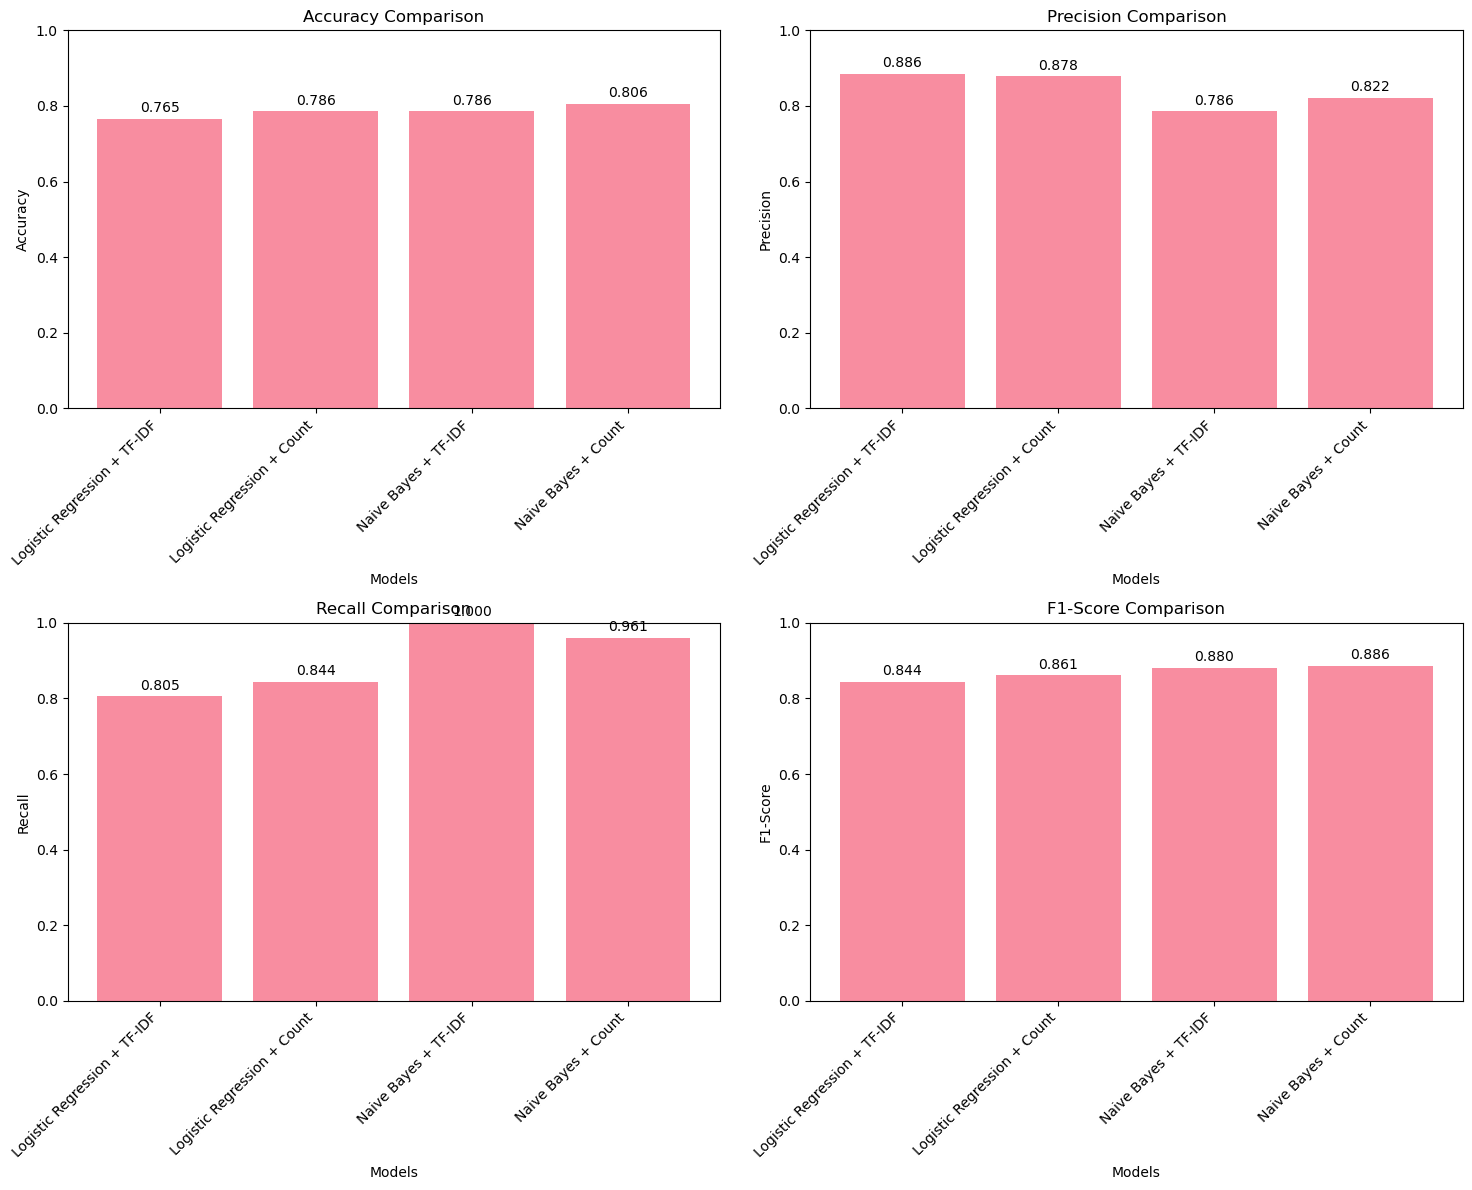


Best performing model: Naive Bayes + Count
F1-Score: 0.8862


In [13]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(performance_df))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(x_pos, performance_df[metric], alpha=0.8)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, performance_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
               f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Find best performing model
best_model_idx = performance_df['F1-Score'].idxmax()
best_model = performance_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")

## 9. Confusion Matrix Analysis

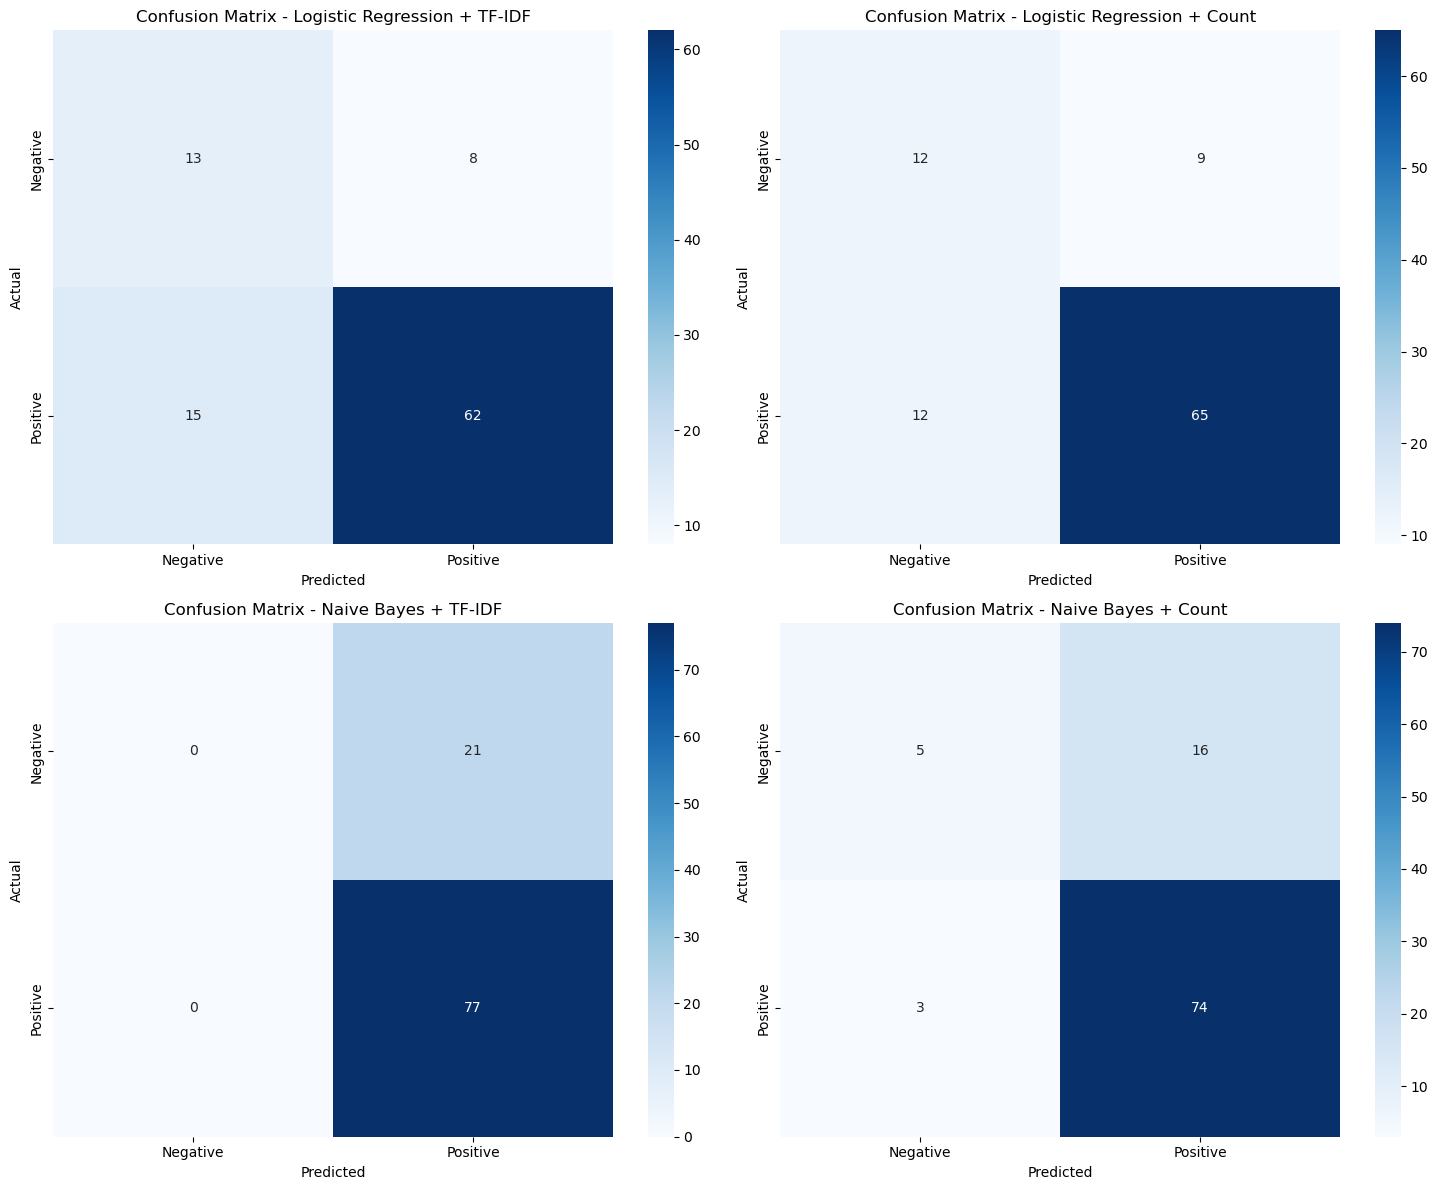

In [14]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

predictions = [
    (y_pred_lr_tfidf, 'Logistic Regression + TF-IDF'),
    (y_pred_lr_count, 'Logistic Regression + Count'),
    (y_pred_nb_tfidf, 'Naive Bayes + TF-IDF'),
    (y_pred_nb_count, 'Naive Bayes + Count')
]

for i, (y_pred, model_name) in enumerate(predictions):
    ax = axes[i//2, i%2]
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 10. Detailed Classification Reports

In [15]:
# Print detailed classification reports
print("=" * 60)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 60)

models_and_predictions = [
    (y_pred_lr_tfidf, 'Logistic Regression + TF-IDF'),
    (y_pred_lr_count, 'Logistic Regression + Count'),
    (y_pred_nb_tfidf, 'Naive Bayes + TF-IDF'),
    (y_pred_nb_count, 'Naive Bayes + Count')
]

for y_pred, model_name in models_and_predictions:
    print(f"\n{model_name}:")
    print("-" * 40)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    print()

DETAILED CLASSIFICATION REPORTS

Logistic Regression + TF-IDF:
----------------------------------------
              precision    recall  f1-score   support

    Negative       0.46      0.62      0.53        21
    Positive       0.89      0.81      0.84        77

    accuracy                           0.77        98
   macro avg       0.68      0.71      0.69        98
weighted avg       0.80      0.77      0.78        98



Logistic Regression + Count:
----------------------------------------
              precision    recall  f1-score   support

    Negative       0.50      0.57      0.53        21
    Positive       0.88      0.84      0.86        77

    accuracy                           0.79        98
   macro avg       0.69      0.71      0.70        98
weighted avg       0.80      0.79      0.79        98



Naive Bayes + TF-IDF:
----------------------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       

## 10a. Per-class metrics summary (focus on Negative class)
We report per-class precision, recall, and F1 for each model, emphasizing performance on the negative class to address class imbalance. Visual comparisons are also provided.


                        Model  Neg_Precision  Neg_Recall  Neg_F1  \
0  LogReg + TF-IDF (balanced)          0.464       0.619   0.531   
1   LogReg + Count (balanced)          0.500       0.571   0.533   
2        Naive Bayes + TF-IDF          0.000       0.000   0.000   
3         Naive Bayes + Count          0.625       0.238   0.345   

   Pos_Precision  Pos_Recall  Pos_F1  
0          0.886       0.805   0.844  
1          0.878       0.844   0.861  
2          0.786       1.000   0.880  
3          0.822       0.961   0.886  


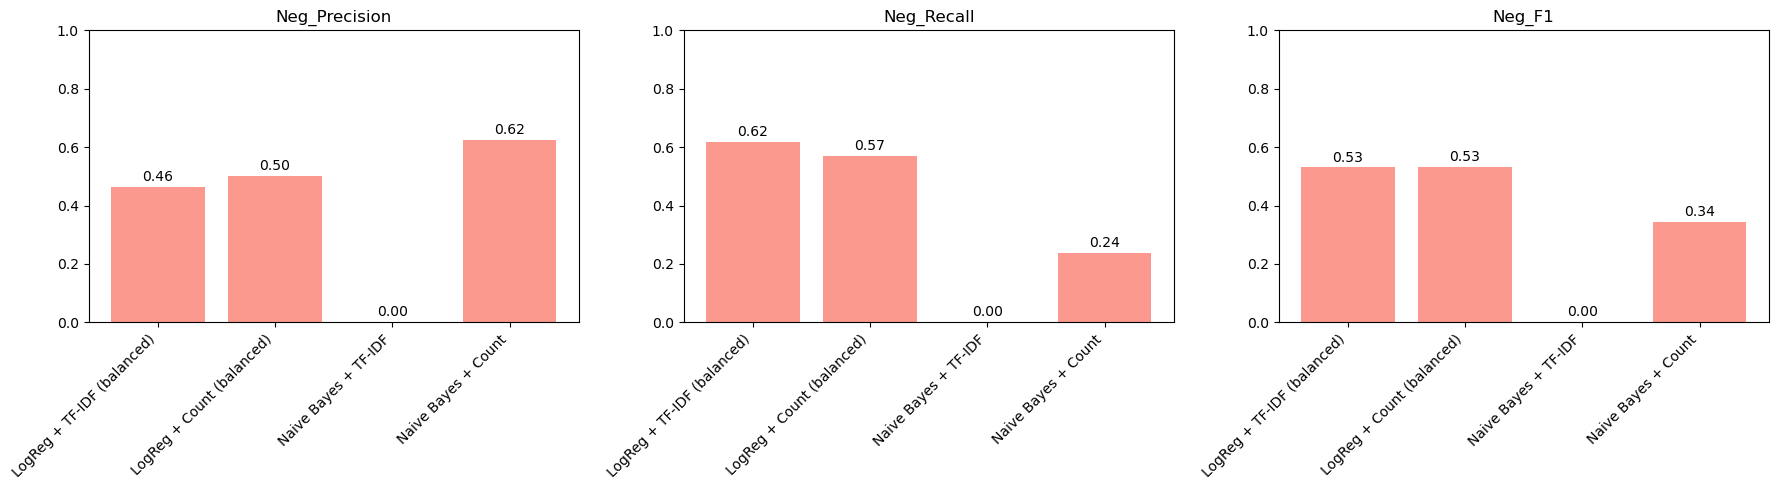

In [ ]:
model_preds = {
    'LogReg + TF-IDF (balanced)': y_pred_lr_tfidf,
    'LogReg + Count (balanced)': y_pred_lr_count,
    'Naive Bayes + TF-IDF': y_pred_nb_tfidf,
    'Naive Bayes + Count': y_pred_nb_count,
}

rows = []
for name, preds in model_preds.items():
    precision, recall, f1, support = precision_recall_fscore_support(y_test, preds, labels=[0,1], zero_division=0)
    # 0=Negative, 1=Positive
    rows.append({
        'Model': name,
        'Neg_Precision': precision[0],
        'Neg_Recall': recall[0],
        'Neg_F1': f1[0],
        'Pos_Precision': precision[1],
        'Pos_Recall': recall[1],
        'Pos_F1': f1[1],
    })

per_class_df = pd.DataFrame(rows)
print(per_class_df.round(3))

# Plot negative-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, ['Neg_Precision', 'Neg_Recall', 'Neg_F1']):
    ax.bar(range(len(per_class_df)), per_class_df[metric], color='salmon', alpha=0.8)
    ax.set_xticks(range(len(per_class_df)))
    ax.set_xticklabels(per_class_df['Model'], rotation=45, ha='right')
    ax.set_title(metric)
    ax.set_ylim(0, 1)
    for i, v in enumerate(per_class_df[metric]):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


## 11. Feature Importance Analysis

In [17]:
# Analyze feature importance for Logistic Regression with TF-IDF (interpretable model)
def get_top_features(model, vectorizer, n_features=20):
    """
    Get top positive and negative features from logistic regression model.
    """
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]
    
    # Get top positive features (indicating positive sentiment)
    top_positive_idx = np.argsort(coefficients)[-n_features:]
    top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
    top_positive_features.reverse()
    
    # Get top negative features (indicating negative sentiment)
    top_negative_idx = np.argsort(coefficients)[:n_features]
    top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_idx]
    
    return top_positive_features, top_negative_features

# Get top features
top_positive, top_negative = get_top_features(lr_tfidf, tfidf_vectorizer, 15)

print("Top 15 features indicating POSITIVE sentiment:")
for i, (feature, coef) in enumerate(top_positive, 1):
    print(f"{i:2d}. {feature:20s} (coef: {coef:6.3f})")

print("\nTop 15 features indicating NEGATIVE sentiment:")
for i, (feature, coef) in enumerate(top_negative, 1):
    print(f"{i:2d}. {feature:20s} (coef: {coef:6.3f})")

Top 15 features indicating POSITIVE sentiment:
 1. great                (coef:  2.279)
 2. love                 (coef:  2.159)
 3. perfect              (coef:  0.971)
 4. excellent            (coef:  0.942)
 5. beautiful            (coef:  0.937)
 6. read                 (coef:  0.811)
 7. good                 (coef:  0.798)
 8. cute                 (coef:  0.746)
 9. reading              (coef:  0.686)
10. easy                 (coef:  0.664)
11. well                 (coef:  0.638)
12. must                 (coef:  0.611)
13. nice                 (coef:  0.611)
14. pretty               (coef:  0.563)
15. enjoyed              (coef:  0.549)

Top 15 features indicating NEGATIVE sentiment:
 1. expected             (coef: -1.346)
 2. didnt                (coef: -1.267)
 3. okay                 (coef: -1.156)
 4. flavor               (coef: -1.075)
 5. cheap                (coef: -1.006)
 6. weak                 (coef: -0.945)
 7. money                (coef: -0.850)
 8. bracelet             

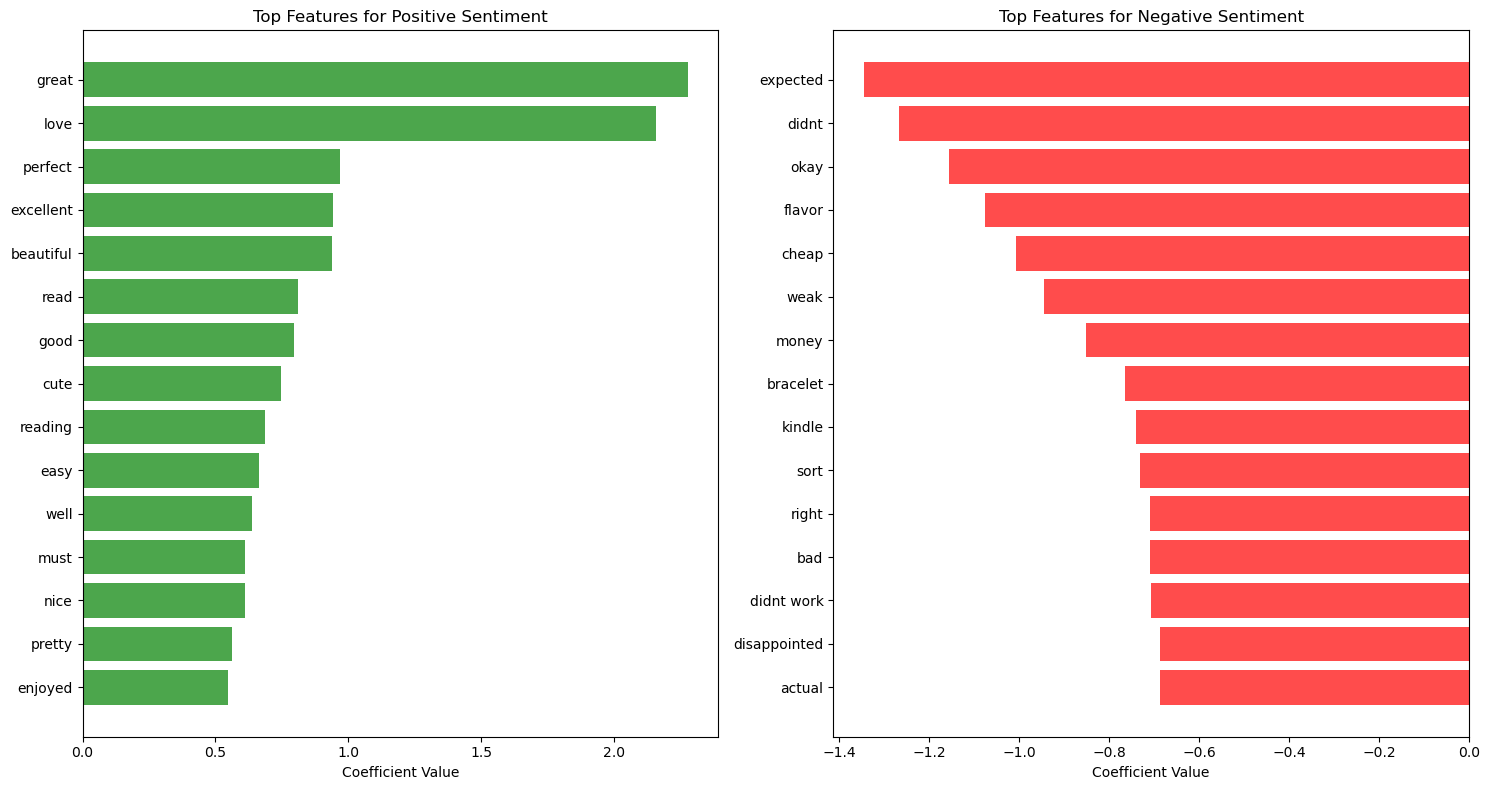

In [18]:
# Visualize top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Top positive features
pos_features, pos_coefs = zip(*top_positive)
ax1.barh(range(len(pos_features)), pos_coefs, color='green', alpha=0.7)
ax1.set_yticks(range(len(pos_features)))
ax1.set_yticklabels(pos_features)
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Top Features for Positive Sentiment')
ax1.invert_yaxis()

# Top negative features
neg_features, neg_coefs = zip(*top_negative)
ax2.barh(range(len(neg_features)), neg_coefs, color='red', alpha=0.7)
ax2.set_yticks(range(len(neg_features)))
ax2.set_yticklabels(neg_features)
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top Features for Negative Sentiment')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 12. Word Cloud Visualization

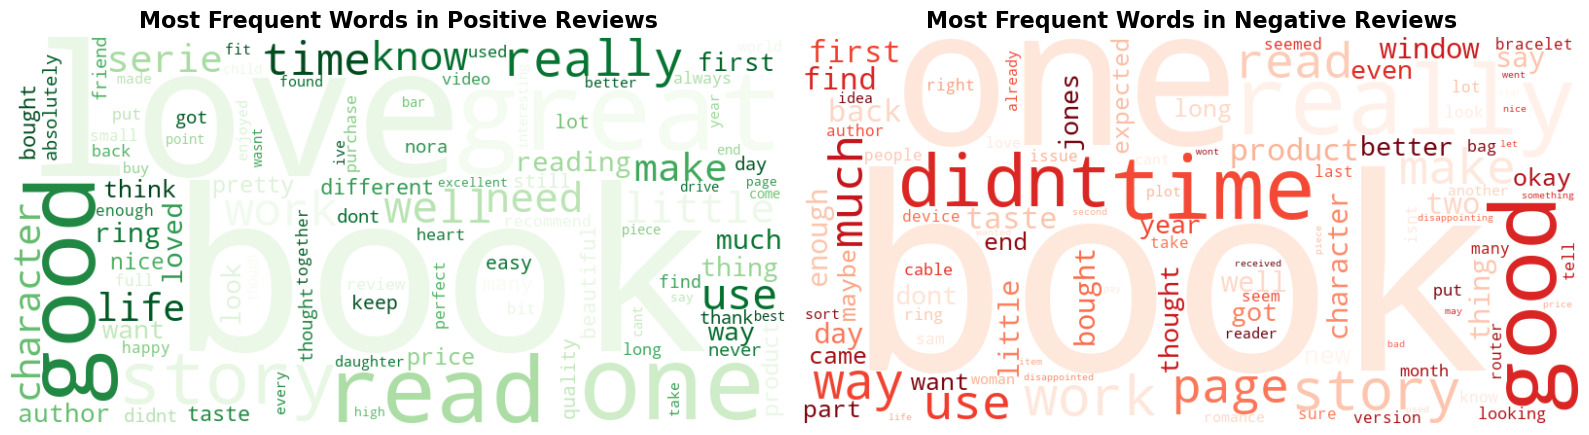

In [19]:
# Create word clouds for positive and negative reviews
def create_wordcloud(text, title, color='viridis'):
    """
    Create a word cloud from text.
    """
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=color,
        max_words=100,
        relative_scaling=0.5,
        random_state=RANDOM_STATE
    ).generate(text)
    
    return wordcloud

# Separate positive and negative reviews
positive_reviews = df_clean[df_clean['sentiment_binary'] == 1]['review_no_stopwords']
negative_reviews = df_clean[df_clean['sentiment_binary'] == 0]['review_no_stopwords']

# Combine text for word clouds
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Create word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive word cloud
positive_wordcloud = create_wordcloud(positive_text, 'Positive Reviews', 'Greens')
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Most Frequent Words in Positive Reviews', fontsize=16, fontweight='bold')
ax1.axis('off')

# Negative word cloud
negative_wordcloud = create_wordcloud(negative_text, 'Negative Reviews', 'Reds')
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Most Frequent Words in Negative Reviews', fontsize=16, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 13. Most Frequent Words Analysis

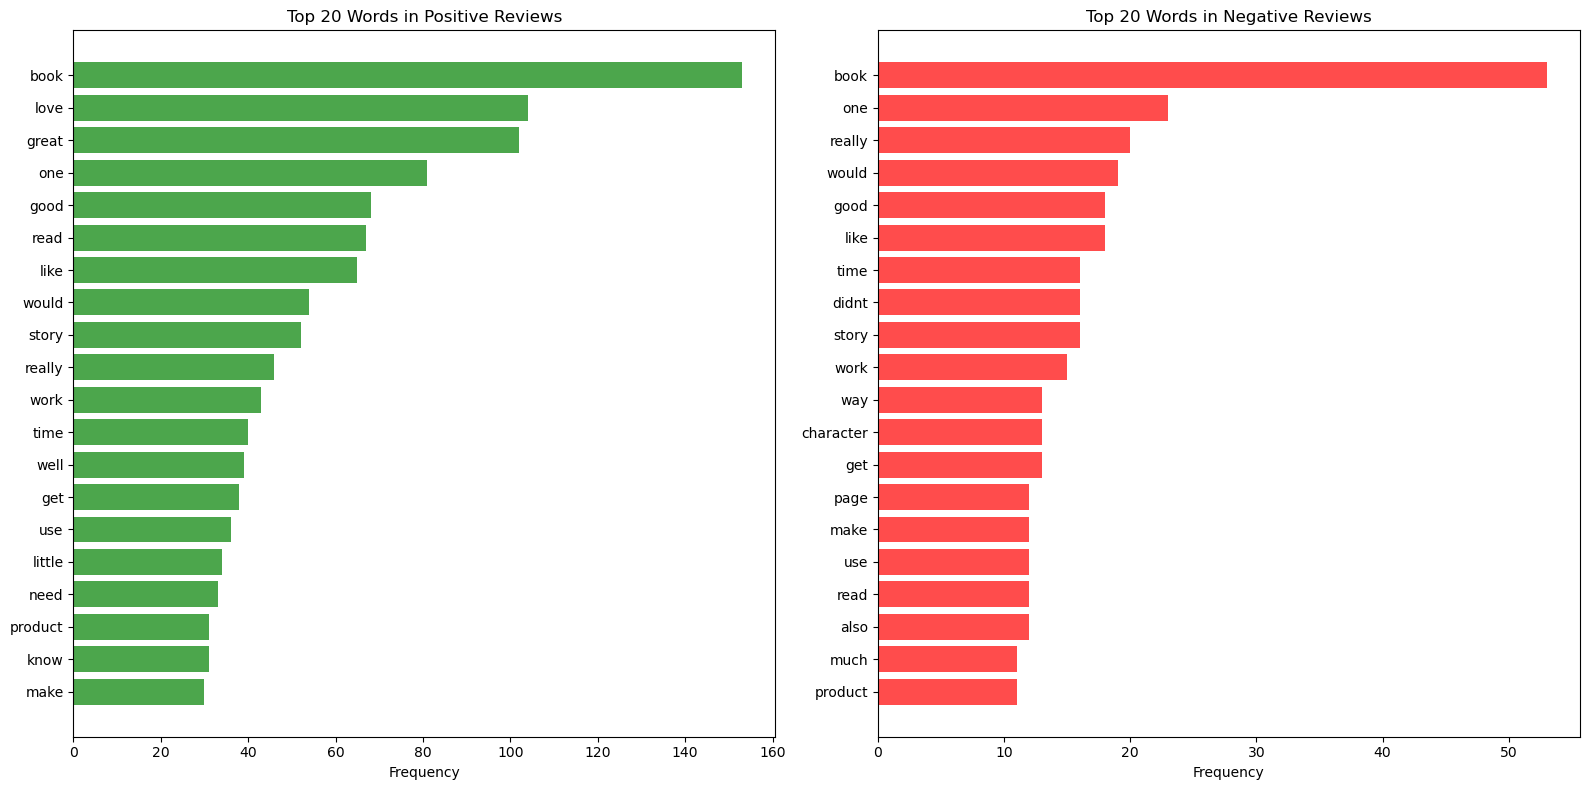

Top 10 words in positive reviews:
book           :   153
love           :   104
great          :   102
one            :    81
good           :    68
read           :    67
like           :    65
would          :    54
story          :    52
really         :    46

Top 10 words in negative reviews:
book           :    53
one            :    23
really         :    20
would          :    19
good           :    18
like           :    18
time           :    16
didnt          :    16
story          :    16
work           :    15


In [20]:
# Analyze most frequent words in positive and negative reviews
def get_most_frequent_words(text, n_words=20):
    """
    Get most frequent words from text.
    """
    words = text.split()
    word_freq = Counter(words)
    return word_freq.most_common(n_words)

# Get most frequent words
top_positive_words = get_most_frequent_words(positive_text, 20)
top_negative_words = get_most_frequent_words(negative_text, 20)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive words
pos_words, pos_counts = zip(*top_positive_words)
ax1.barh(range(len(pos_words)), pos_counts, color='green', alpha=0.7)
ax1.set_yticks(range(len(pos_words)))
ax1.set_yticklabels(pos_words)
ax1.set_xlabel('Frequency')
ax1.set_title('Top 20 Words in Positive Reviews')
ax1.invert_yaxis()

# Negative words
neg_words, neg_counts = zip(*top_negative_words)
ax2.barh(range(len(neg_words)), neg_counts, color='red', alpha=0.7)
ax2.set_yticks(range(len(neg_words)))
ax2.set_yticklabels(neg_words)
ax2.set_xlabel('Frequency')
ax2.set_title('Top 20 Words in Negative Reviews')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 words in positive reviews:")
for word, count in top_positive_words[:10]:
    print(f"{word:15s}: {count:5d}")

print("\nTop 10 words in negative reviews:")
for word, count in top_negative_words[:10]:
    print(f"{word:15s}: {count:5d}")

## 14. Category-wise Sentiment Analysis

Sentiment analysis by category:
sentiment_binary  total  positive_rate  negative_rate
category                                             
books                97          0.835          0.165
ebooks              100          0.820          0.180
grocery              99          0.828          0.172
jewelry              96          0.740          0.260
pc                   94          0.723          0.277


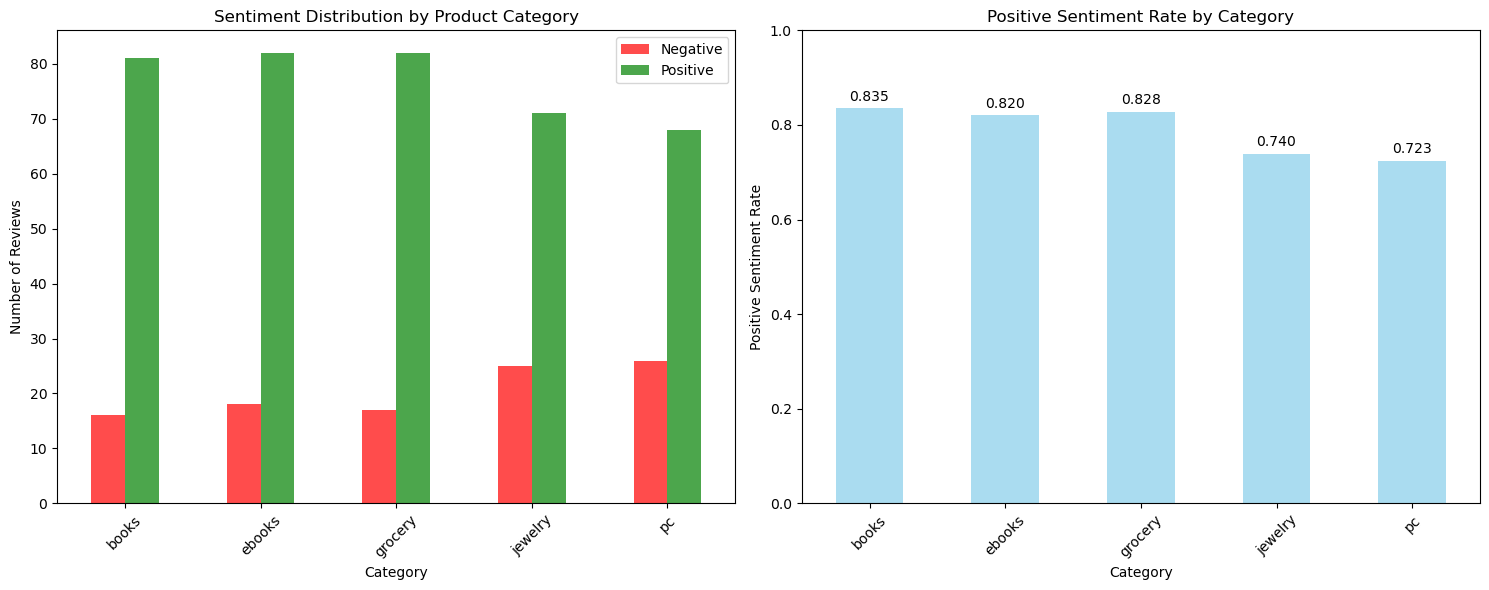

In [21]:
# Analyze sentiment by product category
category_sentiment = df_clean.groupby(['category', 'sentiment_binary']).size().unstack(fill_value=0)
category_sentiment['total'] = category_sentiment.sum(axis=1)
category_sentiment['positive_rate'] = category_sentiment[1] / category_sentiment['total']
category_sentiment['negative_rate'] = category_sentiment[0] / category_sentiment['total']

print("Sentiment analysis by category:")
print(category_sentiment[['total', 'positive_rate', 'negative_rate']].round(3))

# Visualize category-wise sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sentiment distribution by category
category_sentiment[[0, 1]].plot(kind='bar', ax=ax1, color=['red', 'green'], alpha=0.7)
ax1.set_title('Sentiment Distribution by Product Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Reviews')
ax1.legend(['Negative', 'Positive'])
ax1.tick_params(axis='x', rotation=45)

# Positive sentiment rate by category
category_sentiment['positive_rate'].plot(kind='bar', ax=ax2, color='skyblue', alpha=0.7)
ax2.set_title('Positive Sentiment Rate by Category')
ax2.set_xlabel('Category')
ax2.set_ylabel('Positive Sentiment Rate')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(category_sentiment['positive_rate']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 15. Model Testing on Sample Reviews

In [22]:
# Test the best model on sample reviews
def predict_sentiment(text, model, vectorizer):
    """
    Predict sentiment for a given text.
    """
    # Preprocess the text
    clean_text = preprocess_text(text)
    clean_text = remove_stopwords(clean_text)
    
    # Vectorize
    text_vector = vectorizer.transform([clean_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    return prediction, probability

# Sample reviews for testing
sample_reviews = [
    "This product is absolutely amazing! I love it so much. Great quality and fast shipping.",
    "Terrible product. Waste of money. Poor quality and doesn't work as advertised.",
    "It's okay, nothing special but does the job.",
    "Excellent book! Couldn't put it down. Highly recommend to everyone.",
    "Broken item arrived. Very disappointed with the purchase."
]

print("Testing best model (Naive Bayes + Count) on sample reviews:")
print("=" * 80)

for i, review in enumerate(sample_reviews, 1):
    prediction, probability = predict_sentiment(review, nb_count, count_vectorizer)
    sentiment_label = "Positive" if prediction == 1 else "Negative"
    confidence = probability[prediction]
    
    print(f"\nSample {i}:")
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_label} (Confidence: {confidence:.3f})")
    print(f"Probabilities: Negative={probability[0]:.3f}, Positive={probability[1]:.3f}")
    print("-" * 80)

Testing best model (Naive Bayes + Count) on sample reviews:

Sample 1:
Review: This product is absolutely amazing! I love it so much. Great quality and fast shipping.
Predicted Sentiment: Positive (Confidence: 1.000)
Probabilities: Negative=0.000, Positive=1.000
--------------------------------------------------------------------------------

Sample 2:
Review: Terrible product. Waste of money. Poor quality and doesn't work as advertised.
Predicted Sentiment: Negative (Confidence: 0.988)
Probabilities: Negative=0.988, Positive=0.012
--------------------------------------------------------------------------------

Sample 3:
Review: It's okay, nothing special but does the job.
Predicted Sentiment: Negative (Confidence: 0.892)
Probabilities: Negative=0.892, Positive=0.108
--------------------------------------------------------------------------------

Sample 4:
Review: Excellent book! Couldn't put it down. Highly recommend to everyone.
Predicted Sentiment: Positive (Confidence: 1.000)
Pro

## 16. Summary and Conclusions

In [23]:
# Final summary
print("=" * 80)
print("COMPREHENSIVE SENTIMENT ANALYSIS - FINAL SUMMARY")
print("=" * 80)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total reviews analyzed: {len(df_clean):,}")
print(f"   • Product categories: {df_clean['category'].nunique()}")
print(f"   • Positive reviews: {sum(df_clean['sentiment_binary']):,} ({sum(df_clean['sentiment_binary'])/len(df_clean)*100:.1f}%)")
print(f"   • Negative reviews: {len(df_clean) - sum(df_clean['sentiment_binary']):,} ({(len(df_clean) - sum(df_clean['sentiment_binary']))/len(df_clean)*100:.1f}%)")

print(f"\n🔬 MODELS TESTED:")
print(f"   • Logistic Regression with TF-IDF")
print(f"   • Logistic Regression with Count Vectorizer")
print(f"   • Naive Bayes with TF-IDF")
print(f"   • Naive Bayes with Count Vectorizer")

print(f"\n🏆 BEST PERFORMING MODEL:")
best_model = performance_df.loc[performance_df['F1-Score'].idxmax()]
print(f"   • Model: {best_model['Model']}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • Precision: {best_model['Precision']:.4f}")
print(f"   • Recall: {best_model['Recall']:.4f}")
print(f"   • F1-Score: {best_model['F1-Score']:.4f}")

print(f"\n📈 KEY INSIGHTS:")
print(f"   • {category_sentiment['positive_rate'].idxmax().title()} has the highest positive sentiment rate ({category_sentiment['positive_rate'].max():.3f})")
print(f"   • {category_sentiment['positive_rate'].idxmin().title()} has the lowest positive sentiment rate ({category_sentiment['positive_rate'].min():.3f})")
print(f"   • Most common positive word: '{top_positive_words[0][0]}'")
print(f"   • Most common negative word: '{top_negative_words[0][0]}'")

print(f"\n🔍 FEATURE ENGINEERING:")
print(f"   • Text preprocessing: lowercasing, stopword removal, lemmatization, punctuation cleaning")
print(f"   • Vectorization: TF-IDF and Count Vectorizer with n-grams (1,2)")
print(f"   • Feature space: {X_train_tfidf.shape[1]:,} features")

print(f"\n✅ PROJECT COMPLETION:")
print(f"   • ✓ Data loading and preprocessing completed")
print(f"   • ✓ Multiple classifiers trained and evaluated")
print(f"   • ✓ Performance comparison and model selection")
print(f"   • ✓ Comprehensive visualizations created")
print(f"   • ✓ Word frequency and importance analysis")
print(f"   • ✓ Category-wise sentiment analysis")

print("\n" + "=" * 80)
print("SENTIMENT ANALYSIS PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)

COMPREHENSIVE SENTIMENT ANALYSIS - FINAL SUMMARY

📊 DATASET OVERVIEW:
   • Total reviews analyzed: 486
   • Product categories: 5
   • Positive reviews: 384 (79.0%)
   • Negative reviews: 102 (21.0%)

🔬 MODELS TESTED:
   • Logistic Regression with TF-IDF
   • Logistic Regression with Count Vectorizer
   • Naive Bayes with TF-IDF
   • Naive Bayes with Count Vectorizer

🏆 BEST PERFORMING MODEL:
   • Model: Naive Bayes + Count
   • Accuracy: 0.8061
   • Precision: 0.8222
   • Recall: 0.9610
   • F1-Score: 0.8862

📈 KEY INSIGHTS:
   • Books has the highest positive sentiment rate (0.835)
   • Pc has the lowest positive sentiment rate (0.723)
   • Most common positive word: 'book'
   • Most common negative word: 'book'

🔍 FEATURE ENGINEERING:
   • Text preprocessing: lowercasing, stopword removal, lemmatization, punctuation cleaning
   • Vectorization: TF-IDF and Count Vectorizer with n-grams (1,2)
   • Feature space: 1,216 features

✅ PROJECT COMPLETION:
   • ✓ Data loading and preprocessi